# Titanic - Machine Learning from Disaster

1. General inspection.
2. Visualizations.
3. Missing data.
4. Categorical features.
5. Creating/modifying features.
6. Models and predictions.
7. Submit results.

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [2]:
%matplotlib inline
sns.set_style('darkgrid')

In [3]:
data_path = '../input/titanic'

print(os.listdir(data_path))

['train.csv', 'test.csv', 'gender_submission.csv']



- Train and Test sets.
- gender_submission.csv is an example of a submission file for the competition.

In [4]:
train = pd.read_csv(os.path.join(data_path, 'train.csv'), index_col='PassengerId')
test  = pd.read_csv(os.path.join(data_path, 'test.csv'), index_col='PassengerId')

In [5]:
# Create a copy of the original datasets
train_original = train.copy()
test_original  = test.copy()

## 1. General inspection

### Target

- **Survived** (*int*): wheter the passenger survived or not --> 0 = No, 1 = Yes.

### Features

- **Pclass** (*int*): ticket class --> 1 = first class, 2 = second class, 3 = third class.

- **Name** (*str*) (**NOT USED**).

- **Sex** (*str*): male or female.

- **Age** (*float*): age in years (fractional if less than 1; if the age is estimated, it is in the form of xx.5).

- **SibSp** (*int*): number of siblings and spouse that travelled with the passenger.

- **Parch** (*int*): number of childs and parents that travelled with the passenger.

- **Ticket** (*str*): ticket number (**NOT USED**).

- **Fare** (*float*): passenger fare.

- **Cabin** (*str*): cabin number (**NOT USED**).

- **Embarked** (*str*): port of embarkation --> C = Cherbourg, Q = Queenstown, S = Southampton.

In [6]:
target = 'Survived'

In [7]:
# Drop the Ticket, Cabin and Name columns
train = train.drop(['Ticket', 'Cabin', 'Name'], axis=1)
test  = test.drop(['Ticket', 'Cabin', 'Name'], axis=1)

# Set target column as the last column
train = pd.concat([train.loc[:, train.columns != target], train[target]], axis=1)

In [8]:
features = list(test.columns)

print(f'- Number of rows (train) = {len(train)}')
print(f'- Number of rows (test) = {len(test)}')
print(f'- Number of used features = {len(features)} --> {features}')

- Number of rows (train) = 891
- Number of rows (test) = 418
- Number of used features = 7 --> ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


## 2. Visualizations

In [9]:
def annotate_barplot_with_percentages(ax, fontsize=12):
    """Function to annotate barplots with percentages."""

    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / len(train))
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() / 2
        ax.annotate(percentage, (x, y), ha='center', fontsize=fontsize, fontweight='bold')

### Simple plots

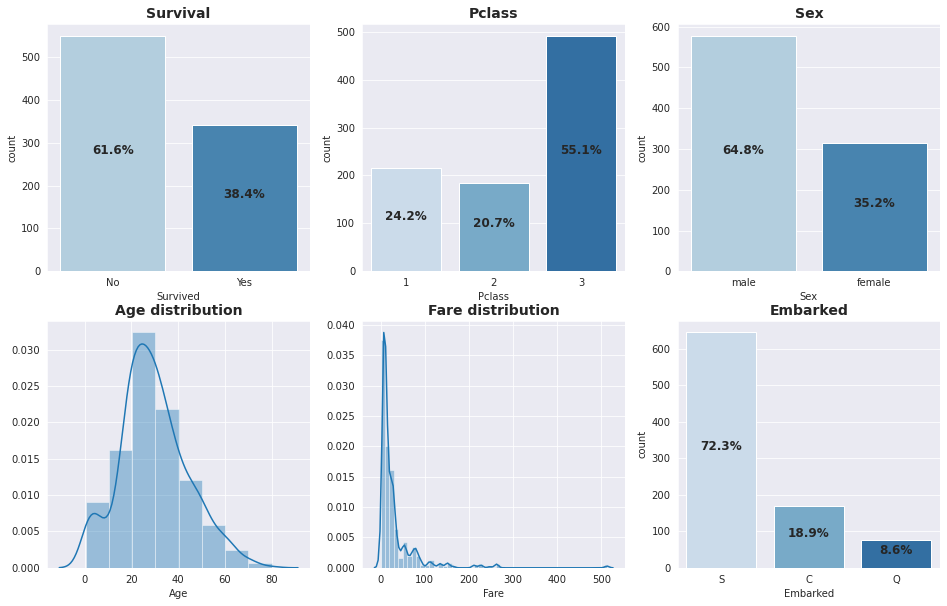

In [10]:
f, axes = plt.subplots(2, 3, figsize=(16, 10))
# Survivors plot
ax_1 = sns.countplot(x=target, data=train, palette='Blues', ax=axes[0, 0])
ax_1.set_title('Survival', fontsize=14, fontweight='bold')
ax_1.set_xticklabels(['No', 'Yes'])
annotate_barplot_with_percentages(ax_1)
# Pclass plot
ax_2 = sns.countplot(x='Pclass', data=train, palette='Blues', ax=axes[0, 1])
ax_2.set_title('Pclass', fontsize=14, fontweight='bold')
annotate_barplot_with_percentages(ax_2)
# Sex plot
ax_3 = sns.countplot(x='Sex', data=train, palette='Blues', ax=axes[0, 2])
ax_3.set_title('Sex', fontsize=14, fontweight='bold')
annotate_barplot_with_percentages(ax_3)
# Age distribution plot
bin_size = 10
ax_4 = sns.distplot(train['Age'], bins=int(train['Age'].max() / bin_size), ax=axes[1, 0])
ax_4.set_title('Age distribution', fontsize=14, fontweight='bold')
# Fare distribution plot
bin_size = 10
ax_5 = sns.distplot(train['Fare'], bins=int(train['Fare'].max() / bin_size), ax=axes[1, 1])
ax_5.set_title('Fare distribution', fontsize=14, fontweight='bold')
# Embarked plot
ax_6 = sns.countplot(x='Embarked', data=train, palette='Blues', ax=axes[1, 2])
ax_6.set_title('Embarked', fontsize=14, fontweight='bold')
annotate_barplot_with_percentages(ax_6)
plt.show()

### Survival plots

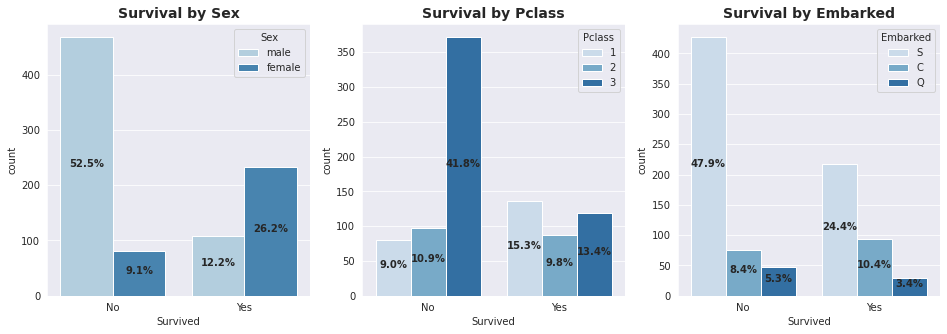

In [11]:
f, axes = plt.subplots(1, 3, figsize=(16, 5))
# Sex hue plot
ax_1 = sns.countplot(x=target, data=train, hue='Sex', palette='Blues', ax=axes[0])
ax_1.set_title('Survival by Sex', fontsize=14, fontweight='bold')
ax_1.set_xticklabels(['No', 'Yes'])
annotate_barplot_with_percentages(ax_1, fontsize=10)
# Pclass hue plot
ax_2 = sns.countplot(x=target, data=train, hue='Pclass', palette='Blues', ax=axes[1])
ax_2.set_title('Survival by Pclass', fontsize=14, fontweight='bold')
ax_2.set_xticklabels(['No', 'Yes'])
annotate_barplot_with_percentages(ax_2, fontsize=10)
# Embarked hue plot
ax_3 = sns.countplot(x=target, data=train, hue='Embarked', palette='Blues', ax=axes[2])
ax_3.set_title('Survival by Embarked', fontsize=14, fontweight='bold')
ax_3.set_xticklabels(['No', 'Yes'])
annotate_barplot_with_percentages(ax_3, fontsize=10)
plt.show()

## 3. Missing data

In [12]:
# Identify features with missing values (NaN)

print('===== TRAIN =====')
for feature_with_nans in train.loc[:, train.isna().sum() > 0]:
    number_of_nans = train[feature_with_nans].isna().sum()
    print(f'- {feature_with_nans} --> {number_of_nans} ({round(100 * number_of_nans / len(train), 2)} %)')

print('\n===== TEST =====')
for feature_with_nans in test.loc[:, test.isna().sum() > 0]:
    number_of_nans = test[feature_with_nans].isna().sum()
    print(f'- {feature_with_nans} --> {number_of_nans} ({round(100 * number_of_nans / len(test), 2)} %)')

===== TRAIN =====
- Age --> 177 (19.87 %)
- Embarked --> 2 (0.22 %)

===== TEST =====
- Age --> 86 (20.57 %)
- Fare --> 1 (0.24 %)


In [13]:
# Impute Age and Fare features with their mean value
simple_imputer = SimpleImputer(strategy='mean')

train['Age'] = simple_imputer.fit_transform(train['Age'].values.reshape(-1, 1))
test['Age']  = simple_imputer.transform(test['Age'].values.reshape(-1, 1))

simple_imputer.fit(train['Fare'].values.reshape(-1, 1))
test['Fare']  = simple_imputer.transform(test['Fare'].values.reshape(-1, 1))

# Impute Embarked feature with the most frequent value
simple_imputer    = SimpleImputer(strategy='most_frequent')
train['Embarked'] = simple_imputer.fit_transform(train['Embarked'].values.reshape(-1, 1))

In [14]:
# Check that there are no more missing values
if (train.isna().sum().sum() == 0) and (test.isna().sum().sum() == 0):
    print('Great! Now there are no missing values.')
else:
    print('Ooops! There are still some missing values.')

Great! Now there are no missing values.


## 4. Categorical features

In [15]:
label_encoder = preprocessing.LabelEncoder()

train['Sex'] = label_encoder.fit_transform(train['Sex'])
test['Sex']  = label_encoder.transform(test['Sex'])

train['Embarked'] = label_encoder.fit_transform(train['Embarked'])
test['Embarked']  = label_encoder.transform(test['Embarked'])

## 5. Creating/modifying features

In [16]:
# Create a feature using SibSp and Parch that indicates if the person was travelling with any relative
train['WithFamily'] = (train['SibSp'] + train['Parch'] > 0).astype(int)
test['WithFamily']  = (test['SibSp'] + test['Parch'] > 0).astype(int)

train = train.drop(['SibSp', 'Parch'], axis=1)
test  = test.drop(['SibSp', 'Parch'], axis=1)

# Set target column as the last column
train = pd.concat([train.loc[:, train.columns != target], train[target]], axis=1)

In [17]:
def categorize_age(age):
    """Function to categorize the age."""

    if age < 10:
        category = 1
    elif age < 20:
        category = 2
    elif age < 30:
        category = 3
    elif age < 40:
        category = 4
    elif age < 50:
        category = 5
    elif age < 60:
        category = 6
    elif age < 70:
        category = 7
    elif age < 80:
        category = 8
    else:
        category = 9

    return category

In [18]:
# Categorize the Age feature in decades (0-10 -> 1, 10-20 -> 2, ...)
train['Age'] = train['Age'].apply(categorize_age)

In [19]:
def categorize_fare(fare):
    """Function to categorize the fare."""

    if fare < 10:
        category = 1
    elif fare < 20:
        category = 2
    elif fare < 30:
        category = 3
    elif fare < 40:
        category = 4
    elif fare < 50:
        category = 5
    elif fare < 60:
        category = 6
    elif fare < 70:
        category = 7
    elif fare < 80:
        category = 8
    elif fare < 90:
        category = 9
    else:
        category = 10

    return category

In [20]:
# Categorize the Fare feature
train['Fare'] = train['Fare'].apply(categorize_fare)

## 6. Models and predictions

In [21]:
X_train = train.loc[:, train.columns != target]
y_train = train[target]

X_test = test

### Random Forest Classifier

In [22]:
rf_classifier = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rf_classifier.fit(X_train, y_train)
train_pred = rf_classifier.predict(X_train)
train_cv_accuracy = cross_val_score(rf_classifier, X_train, y_train, scoring='accuracy', cv=5).mean()
print(f'Accuracy with RandomForestClassifier (train) = {train_cv_accuracy}')

Accuracy with RandomForestClassifier (train) = 0.8125855250768941


## 7. Submit results

In [23]:
test_pred = rf_classifier.predict(X_test)

In [24]:
output_df = pd.DataFrame({'PassengerId': test.index, 'Survived': test_pred})
output_df.to_csv('rfc_2.csv', index=False)